# Fine-tuning FLAN-T5-base with Classification Head for Multi-Label Toxic Comment Classification

This notebook outlines the process for fine-tuning the `google/flan-t5-base` model from Hugging Face on a multi-label toxic comment classification task using a classification head approach.
The fine-tuning is performed on Kaggle using a Nvidia P100 GPU with LoRA (Low-Rank Adaptation) for parameter-efficient training.

## Key Features:
- **Model**: FLAN-T5-base with custom classification head
- **Task**: Multi-label toxic comment classification
- **Approach**: Classification head (not text-to-text generation)
- **Training Data**: 20% subsample of original dataset for faster training
- **Optimization**: LoRA adapters for memory efficiency

In [2]:
!pip install -U "numpy<2.0" "matplotlib==3.8.2" scikit-learn pandas "bitsandbytes==0.43.0" "transformers==4.44.2" "accelerate==0.33.0" "peft==0.12.0" seaborn tqdm "torch==2.4.0" --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 248.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 250.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 218.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 235.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 273.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 202.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 229.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 260.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 339.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 333.6 MB/s eta 0:00:0

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Force single GPU usage
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    T5EncoderModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

2025-06-22 12:33:08.897118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750595589.112639      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750595589.170497      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PyTorch version: 2.4.0+cu121
CUDA available: True
CUDA device count: 1
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15.9 GB


In [ ]:
#  Configuration
MODEL_NAME = "google/flan-t5-base"

# Model configuration for training
EFFECTIVE_MAX_LENGTH = 512  
MAX_LENGTH = EFFECTIVE_MAX_LENGTH
BATCH_SIZE = 8  # Reduced batch size due to larger model
LEARNING_RATE = 1e-4  
NUM_EPOCHS = 3
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

# Training data subsampling configuration
TRAINING_SUBSAMPLE_FRACTION = 0.2  # Use 20% of training data after split
USE_TRAINING_SUBSAMPLING = True

# Quantization configuration
USE_QUANTIZATION = True  # Enable quantization to force single device usage
if USE_QUANTIZATION and torch.cuda.is_available():
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    print("Using 4-bit quantization with NF4")
else:
    quantization_config = None
    print("No quantization - using full precision")

# LoRA configuration
USE_LORA = True  # Use LoRA for parameter-efficient fine-tuning
LORA_R = 16  
LORA_ALPHA = 32  # Alpha parameter
LORA_DROPOUT = 0.1
# Target modules for T5 encoder
LORA_TARGET_MODULES = ["q", "v", "k", "o", "wi", "wo"]  # T5 attention and feed-forward layers

# Update paths
TRAIN_DATA_PATH = "/kaggle/input/jigsaw-toxic-comment-classification-preprocessed/jigsaw-toxic-comment-classification-preprocessed/train_preprocessed.csv" 

OUTPUT_DIR = "/kaggle/working/"
TEXT_COLUMN = "comment_text" 
LABEL_COLUMNS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
NUM_LABELS = len(LABEL_COLUMNS)

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device configuration will be handled by quantization and device_map
print(f"Quantization enabled: {USE_QUANTIZATION}")
print(f"LoRA enabled: {USE_LORA}")
print(f"Training data subsampling: {USE_TRAINING_SUBSAMPLING} ({TRAINING_SUBSAMPLE_FRACTION*100}% of data)")
print(f"Expected memory usage: Lower with quantization + LoRA")

# Load tokenizer
print("Loading T5 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Set pad_token to eos_token: {tokenizer.pad_token}")
else:
    print(f"Using existing pad token: {tokenizer.pad_token}")

print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")


Using 4-bit quantization with NF4
Quantization enabled: True
LoRA enabled: True
Training data subsampling: True (20.0% of data)
Expected memory usage: Lower with quantization + LoRA
Loading T5 tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Using existing pad token: <pad>
Tokenizer loaded. Vocab size: 32100


In [ ]:
# Custom T5 Model for Classification
class T5ForClassification(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.1):
        super(T5ForClassification, self).__init__()
        # Load T5 encoder only
        self.encoder = T5EncoderModel.from_pretrained(model_name)
        
        # Get hidden size from the encoder config
        self.hidden_size = self.encoder.config.d_model
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.hidden_size, self.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.hidden_size // 2, num_labels)
        )
        
        # Store configuration for compatibility
        self.config = self.encoder.config
        self.config.num_labels = num_labels
        self.config.problem_type = "multi_label_classification"
        
        # Initialize classifier weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize the weights of the classification head"""
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.bias is not None:
                    module.bias.data.zero_()
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Get encoder outputs
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Use the last hidden state
        sequence_output = encoder_outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Pool the sequence (mean pooling over sequence length, excluding padding)
        if attention_mask is not None:
            # Apply attention mask and compute mean
            mask_expanded = attention_mask.unsqueeze(-1).expand(sequence_output.size()).float()
            sum_embeddings = torch.sum(sequence_output * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            pooled_output = sum_embeddings / sum_mask
        else:
            # Simple mean if no attention mask
            pooled_output = torch.mean(sequence_output, dim=1)
        
        # Get logits from classifier
        logits = self.classifier(pooled_output)
        
        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())
        
        # Return in the format expected by Transformers
        from transformers.modeling_outputs import SequenceClassifierOutput
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None
        )
    
    def resize_token_embeddings(self, new_num_tokens):
        """Resize token embeddings to match tokenizer"""
        return self.encoder.resize_token_embeddings(new_num_tokens)
    
    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        """Enable gradient checkpointing for the encoder"""
        if hasattr(self.encoder, 'gradient_checkpointing_enable'):
            self.encoder.gradient_checkpointing_enable(gradient_checkpointing_kwargs)
    
    def gradient_checkpointing_disable(self):
        """Disable gradient checkpointing for the encoder"""
        if hasattr(self.encoder, 'gradient_checkpointing_disable'):
            self.encoder.gradient_checkpointing_disable()
    
    def save_pretrained(self, save_directory):
        """Save the model"""
        os.makedirs(save_directory, exist_ok=True)
        
        # Save the encoder
        self.encoder.save_pretrained(save_directory)
        
        # Save the classifier head
        classifier_path = os.path.join(save_directory, "classifier_head.pt")
        torch.save(self.classifier.state_dict(), classifier_path)
        
        # Save model config
        config_path = os.path.join(save_directory, "model_config.json")
        import json
        with open(config_path, "w") as f:
            json.dump({
                "model_type": "T5ForClassification",
                "base_model": "google/flan-t5-base",
                "num_labels": self.config.num_labels,
                "hidden_size": self.hidden_size
            }, f, indent=2)
    
    @classmethod
    def from_pretrained(cls, model_path, num_labels):
        """Load the model from a saved directory"""
        # Load the encoder
        encoder = T5EncoderModel.from_pretrained(model_path)
        
        # Create the model
        model = cls.__new__(cls)
        super(T5ForClassification, model).__init__()
        model.encoder = encoder
        model.hidden_size = encoder.config.d_model
        model.config = encoder.config
        model.config.num_labels = num_labels
        
        # Recreate classifier
        model.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(model.hidden_size, model.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(model.hidden_size // 2, num_labels)
        )
        
        # Load classifier weights
        classifier_path = os.path.join(model_path, "classifier_head.pt")
        if os.path.exists(classifier_path):
            model.classifier.load_state_dict(torch.load(classifier_path))
        
        return model

print("T5ForClassification class defined successfully")

T5ForClassification class defined successfully


In [6]:
def oversample_minority_classes(X_train, y_train):
    """Oversample minority classes to improve balance"""
    original_X = X_train.copy()
    original_y = y_train.copy()
    augmented_X = []
    augmented_y = []
    
    # Print original distribution
    print("Class distribution BEFORE oversampling:")
    for col in y_train.columns:
        positive_count = y_train[col].sum()
        total_count = len(y_train)
        print(f"{col}: {positive_count}/{total_count} ({positive_count/total_count*100:.2f}%)")
    
    multipliers = {
        'threat': 40,
        'identity_hate': 20,
        'severe_toxic': 15
    }
    
    for label, multiplier in multipliers.items():
        # Add error handling for missing labels
        if label not in y_train.columns:
            print(f"Warning: Label '{label}' not found in data, skipping...")
            continue
            
        pos_indices = y_train[y_train[label] == 1].index
        
        # Check if there are any positive samples
        if len(pos_indices) == 0:
            print(f"Warning: No positive samples found for '{label}', skipping...")
            continue
            
        pos_X = X_train.loc[pos_indices]
        pos_y = y_train.loc[pos_indices]
        
        print(f"Oversampling {label}: {len(pos_indices)} samples × {multiplier-1} = {len(pos_indices)*(multiplier-1)} additional samples")
        
        for _ in range(multiplier - 1):
            augmented_X.append(pos_X)
            augmented_y.append(pos_y)
    
    # Handle case where no augmentation occurred
    if augmented_X:
        augmented_X = pd.concat([original_X] + augmented_X, ignore_index=True)
        augmented_y = pd.concat([original_y] + augmented_y, ignore_index=True)
    else:
        print("No oversampling performed")
        augmented_X = original_X
        augmented_y = original_y
    
    print(f"\nDataset size: {len(original_X)} → {len(augmented_X)} (+{len(augmented_X)-len(original_X)} samples)")
    
    print("Class distribution AFTER oversampling:")
    for col in augmented_y.columns:
        positive_count = augmented_y[col].sum()
        total_count = len(augmented_y)
        print(f"{col}: {positive_count}/{total_count} ({positive_count/total_count*100:.2f}%)")
    
    return augmented_X.reset_index(drop=True), augmented_y.reset_index(drop=True)

Loading preprocessed training data...
 Training data loaded successfully: (159571, 9)

Original training data columns:
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'processed_text']

 All required columns found in training data

First few rows of original training data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             

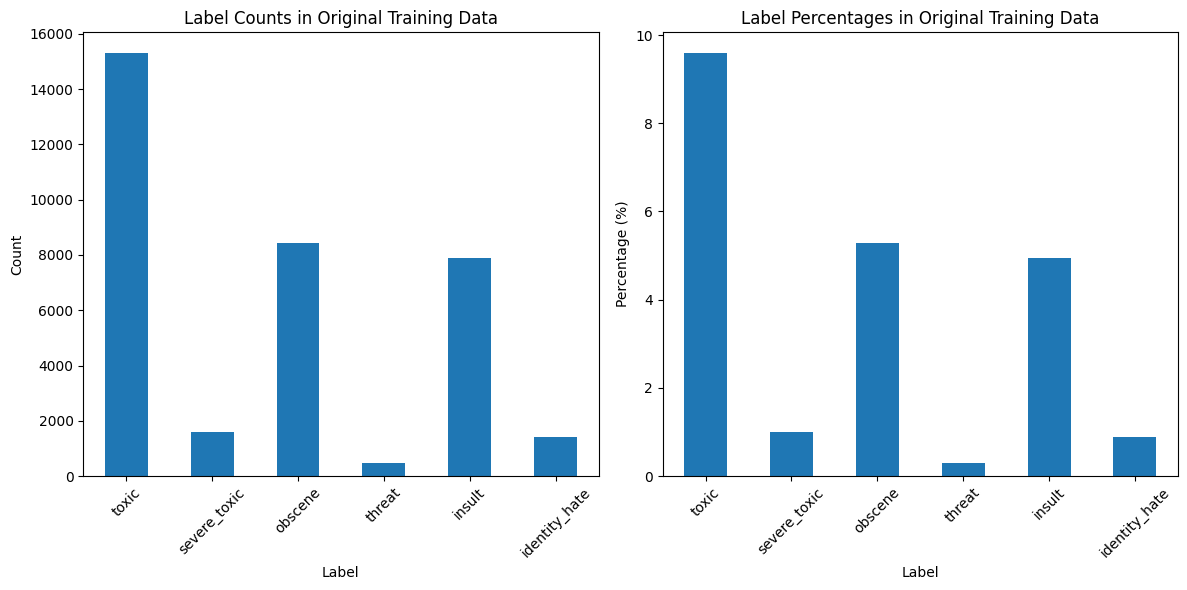


SPLITTING DATA INTO TRAIN/VALIDATION/TEST
Data split completed:
- Training set: 111,763 samples (70.0%)
- Validation set: 23,872 samples (15.0%)
- Test set: 23,936 samples (15.0%)
- Total: 159,571 samples

 Split datasets saved:
- Training data: /kaggle/working//train_split.csv
- Validation data: /kaggle/working//val_split.csv
- Test data (with labels): /kaggle/working//test_split_with_labels.csv
- Test data (without labels): /kaggle/working//test_split_no_labels.csv

 LABEL DISTRIBUTION COMPARISON:
------------------------------------------------------------

Label counts and percentages by split:
     Split   Size  toxic_count  toxic_pct  severe_toxic_count  severe_toxic_pct  obscene_count  obscene_pct  threat_count  threat_pct  insult_count  insult_pct  identity_hate_count  identity_hate_pct
  Original 159571        15294   9.584448                1595          0.999555           8449     5.294822           478    0.299553          7877    4.936361                 1405           0.

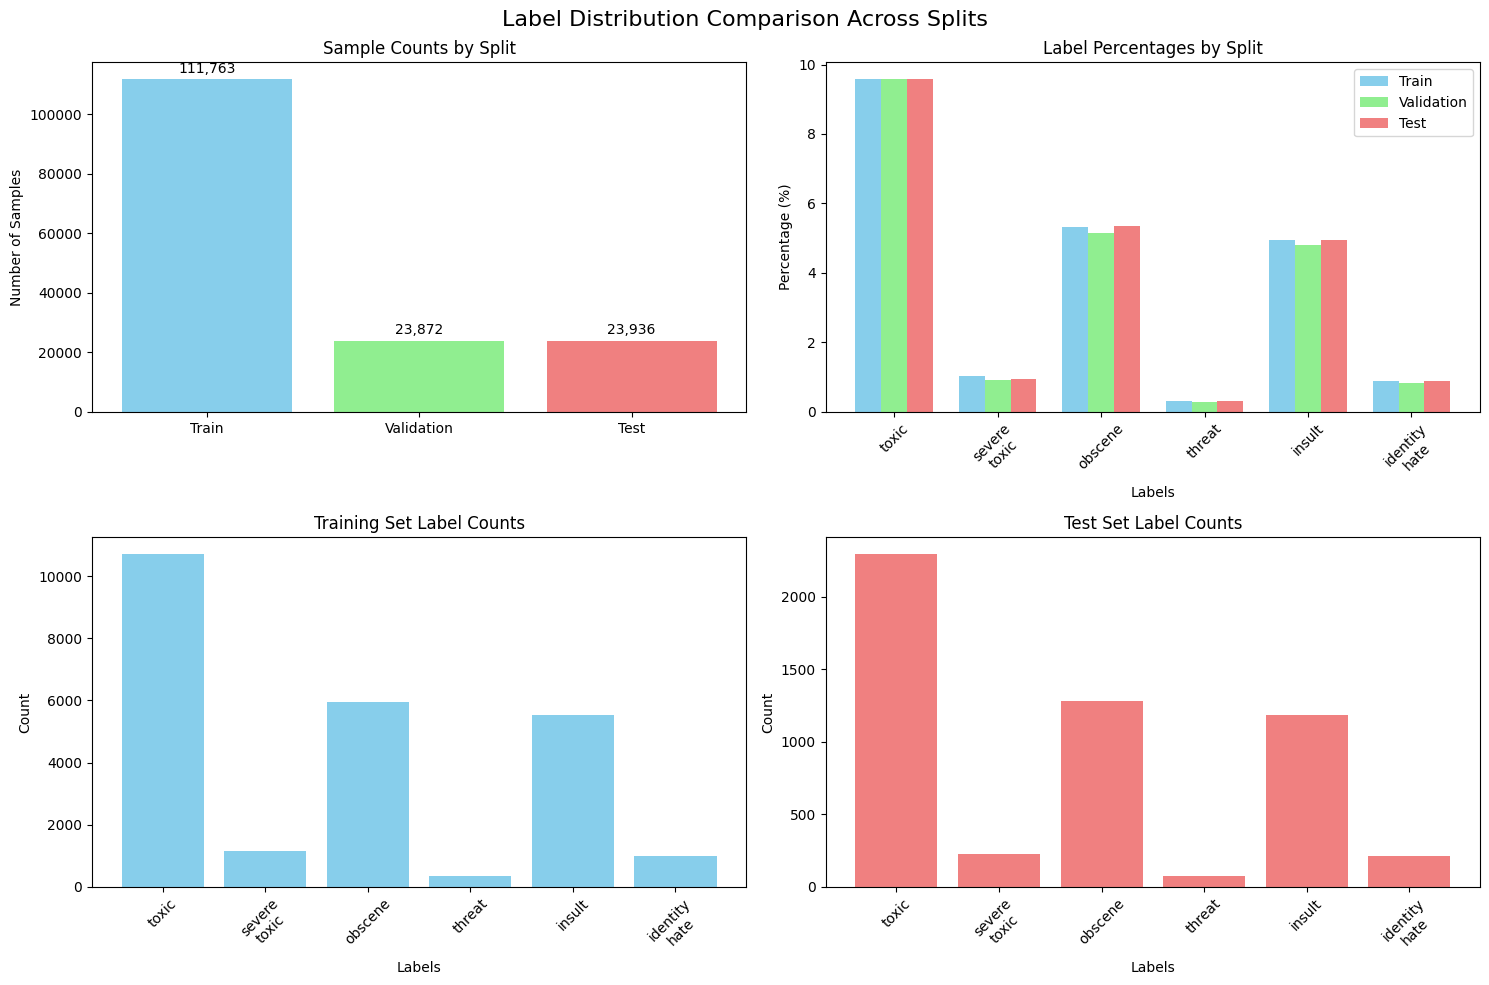


 Updating paths for training process...
Updated paths:
- TRAIN_DATA_PATH: /kaggle/working//train_split.csv
- VAL_DATA_PATH: /kaggle/working//val_split.csv
- TEST_DATA_PATH: /kaggle/working//test_split_no_labels.csv
- TEST_WITH_LABELS_PATH: /kaggle/working//test_split_with_labels.csv

 Data splitting completed successfully!
Ready to proceed with training using the split data.


In [7]:
# Load and Split Dataset into Train/Validation/Test
print("Loading preprocessed training data...")
try:
    full_train_df = pd.read_csv(TRAIN_DATA_PATH)
    print(f" Training data loaded successfully: {full_train_df.shape}")
except FileNotFoundError:
    print(f" Training data not found at: {TRAIN_DATA_PATH}")
    print("Please update paths in the configuration section")
    raise

# Display basic information about the data
print("\nOriginal training data columns:")
print(full_train_df.columns.tolist())

# Check if required columns exist
required_columns = [TEXT_COLUMN] + LABEL_COLUMNS
missing_columns = [col for col in required_columns if col not in full_train_df.columns]

if missing_columns:
    print(f"\n Missing required columns in training data: {missing_columns}")
    print(f"Available columns: {full_train_df.columns.tolist()}")
    print("\nPlease ensure your preprocessed data has the following columns:")
    print(f"- {TEXT_COLUMN} (the processed text)")
    print(f"- {', '.join(LABEL_COLUMNS)} (label columns)")
    raise ValueError("Missing required columns")
else:
    print("\n All required columns found in training data")

print("\nFirst few rows of original training data:")
print(full_train_df.head())

# Check label distribution in original data
print("\nLabel distribution in original training data:")
label_stats = full_train_df[LABEL_COLUMNS].sum()
print(label_stats)

# Calculate percentage of positive labels
print("\nPercentage of positive labels:")
label_percentages = (full_train_df[LABEL_COLUMNS].sum() / len(full_train_df)) * 100
print(label_percentages)

# Visualize original label distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
label_stats.plot(kind='bar')
plt.title('Label Counts in Original Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
label_percentages.plot(kind='bar')
plt.title('Label Percentages in Original Training Data')
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Split the data into train/validation/test (70%/15%/15%)
print("\n" + "="*50)
print("SPLITTING DATA INTO TRAIN/VALIDATION/TEST")
print("="*50)

# First split: separate test set (15% of total data)
train_val_df, test_df = train_test_split(
    full_train_df, 
    test_size=0.15, 
    random_state=42,
    stratify=full_train_df[LABEL_COLUMNS[0]]  # Stratify on primary toxic label
)

# Second split: separate validation from remaining data (15% of total = ~17.6% of remaining)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.176,  # This gives us ~15% of original data for validation
    random_state=42,
    stratify=train_val_df[LABEL_COLUMNS[0]]  # Stratify on primary toxic label
)

print(f"Data split completed:")
print(f"- Training set: {len(train_df):,} samples ({len(train_df)/len(full_train_df)*100:.1f}%)")
print(f"- Validation set: {len(val_df):,} samples ({len(val_df)/len(full_train_df)*100:.1f}%)")
print(f"- Test set: {len(test_df):,} samples ({len(test_df)/len(full_train_df)*100:.1f}%)")
print(f"- Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

# Create test set without labels for prediction
test_df_no_labels = test_df[[TEXT_COLUMN]].copy()
if 'id' not in test_df.columns:
    # Create an ID column if it doesn't exist
    test_df_no_labels['id'] = range(len(test_df_no_labels))
    test_df['id'] = range(len(test_df))
else:
    test_df_no_labels['id'] = test_df['id'].copy()

# Save the split datasets
train_split_path = f"{OUTPUT_DIR}/train_split.csv"
val_split_path = f"{OUTPUT_DIR}/val_split.csv"
test_split_with_labels_path = f"{OUTPUT_DIR}/test_split_with_labels.csv"
test_split_no_labels_path = f"{OUTPUT_DIR}/test_split_no_labels.csv"

train_df.to_csv(train_split_path, index=False)
val_df.to_csv(val_split_path, index=False)
test_df.to_csv(test_split_with_labels_path, index=False)
test_df_no_labels.to_csv(test_split_no_labels_path, index=False)

print(f"\n Split datasets saved:")
print(f"- Training data: {train_split_path}")
print(f"- Validation data: {val_split_path}")
print(f"- Test data (with labels): {test_split_with_labels_path}")
print(f"- Test data (without labels): {test_split_no_labels_path}")

# Compare label distributions across splits
print(f"\n LABEL DISTRIBUTION COMPARISON:")
print("-" * 60)

splits_info = {
    'Original': full_train_df,
    'Train': train_df,
    'Validation': val_df,
    'Test': test_df
}

comparison_data = []
for split_name, split_df in splits_info.items():
    row = {'Split': split_name, 'Size': len(split_df)}
    for label in LABEL_COLUMNS:
        count = split_df[label].sum()
        percentage = (count / len(split_df)) * 100
        row[f'{label}_count'] = count
        row[f'{label}_pct'] = percentage
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\nLabel counts and percentages by split:")
print(comparison_df.to_string(index=False))

# Visualize distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Label Distribution Comparison Across Splits', fontsize=16)

# Plot 1: Sample counts
splits = ['Train', 'Validation', 'Test']
sizes = [len(train_df), len(val_df), len(test_df)]
axes[0, 0].bar(splits, sizes, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Sample Counts by Split')
axes[0, 0].set_ylabel('Number of Samples')
for i, v in enumerate(sizes):
    axes[0, 0].text(i, v + max(sizes)*0.01, f'{v:,}', ha='center', va='bottom')

# Plot 2: Label percentages for each split
label_pcts = {
    'Train': [(train_df[label].sum() / len(train_df)) * 100 for label in LABEL_COLUMNS],
    'Validation': [(val_df[label].sum() / len(val_df)) * 100 for label in LABEL_COLUMNS],
    'Test': [(test_df[label].sum() / len(test_df)) * 100 for label in LABEL_COLUMNS]
}

x = np.arange(len(LABEL_COLUMNS))
width = 0.25

axes[0, 1].bar(x - width, label_pcts['Train'], width, label='Train', color='skyblue')
axes[0, 1].bar(x, label_pcts['Validation'], width, label='Validation', color='lightgreen')
axes[0, 1].bar(x + width, label_pcts['Test'], width, label='Test', color='lightcoral')

axes[0, 1].set_title('Label Percentages by Split')
axes[0, 1].set_xlabel('Labels')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([label.replace('_', '\n') for label in LABEL_COLUMNS], rotation=45)
axes[0, 1].legend()

# Plot 3: Training set label distribution (bar chart)
train_label_counts = [train_df[label].sum() for label in LABEL_COLUMNS]
axes[1, 0].bar(range(len(LABEL_COLUMNS)), train_label_counts, color='skyblue')
axes[1, 0].set_title('Training Set Label Counts')
axes[1, 0].set_xlabel('Labels')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(range(len(LABEL_COLUMNS)))
axes[1, 0].set_xticklabels([label.replace('_', '\n') for label in LABEL_COLUMNS], rotation=45)

# Plot 4: Test set label distribution (bar chart)
test_label_counts = [test_df[label].sum() for label in LABEL_COLUMNS]
axes[1, 1].bar(range(len(LABEL_COLUMNS)), test_label_counts, color='lightcoral')
axes[1, 1].set_title('Test Set Label Counts')
axes[1, 1].set_xlabel('Labels')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(range(len(LABEL_COLUMNS)))
axes[1, 1].set_xticklabels([label.replace('_', '\n') for label in LABEL_COLUMNS], rotation=45)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/data_split_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Update paths for the training process
print(f"\n Updating paths for training process...")
TRAIN_DATA_PATH = train_split_path
VAL_DATA_PATH = val_split_path
TEST_DATA_PATH = test_split_no_labels_path  # Use the version without labels for prediction
TEST_WITH_LABELS_PATH = test_split_with_labels_path  # Keep reference to version with labels

print(f"Updated paths:")
print(f"- TRAIN_DATA_PATH: {TRAIN_DATA_PATH}")
print(f"- VAL_DATA_PATH: {VAL_DATA_PATH}")
print(f"- TEST_DATA_PATH: {TEST_DATA_PATH}")
print(f"- TEST_WITH_LABELS_PATH: {TEST_WITH_LABELS_PATH}")

# Use the split data for training
train_df_split = train_df.copy()
val_df_split = val_df.copy()
test_df = test_df_no_labels.copy()  # This will be used for prediction

print(f"\n Data splitting completed successfully!")
print(f"Ready to proceed with training using the split data.")

In [ ]:
print("Preparing training data with subsampling and oversampling...")

# Apply subsampling if enabled
if USE_TRAINING_SUBSAMPLING and TRAINING_SUBSAMPLE_FRACTION < 1.0:
    print(f"\n" + "="*50)
    print(f"SUBSAMPLING TRAINING DATA TO {TRAINING_SUBSAMPLE_FRACTION*100}%")
    print("="*50)
    
    original_train_size = len(train_df_split)
    subsample_size = int(original_train_size * TRAINING_SUBSAMPLE_FRACTION)
    
    print(f"Original training set size: {original_train_size:,}")
    print(f"Subsampling to: {subsample_size:,} samples ({TRAINING_SUBSAMPLE_FRACTION*100}%)")
    
    # Perform stratified subsampling to maintain label distribution
    train_df_subsampled = train_df_split.sample(
        n=subsample_size, 
        random_state=42, 
        replace=False
    ).reset_index(drop=True)
    
    print(f"\nLabel distribution comparison:")
    print("Original training set:")
    for label in LABEL_COLUMNS:
        orig_count = train_df_split[label].sum()
        orig_pct = (orig_count / len(train_df_split)) * 100
        print(f"  {label}: {orig_count:,} ({orig_pct:.2f}%)")
    
    print("\nSubsampled training set:")
    for label in LABEL_COLUMNS:
        sub_count = train_df_subsampled[label].sum()
        sub_pct = (sub_count / len(train_df_subsampled)) * 100
        print(f"  {label}: {sub_count:,} ({sub_pct:.2f}%)")
    
    # Use subsampled data for training
    train_df_for_training = train_df_subsampled
    print(f"\nUsing subsampled training dataset: {len(train_df_for_training):,} samples")
else:
    print("Using full training dataset (no subsampling)")
    train_df_for_training = train_df_split
    print(f"Training samples: {len(train_df_for_training):,}")

# Extract texts and labels from the training data to use
train_texts = train_df_for_training[TEXT_COLUMN].fillna('').tolist()
train_labels = train_df_for_training[LABEL_COLUMNS].values.astype(float)

# Convert to DataFrame for oversampling
train_df_for_oversampling = pd.DataFrame({
    TEXT_COLUMN: train_texts
})
train_labels_df = pd.DataFrame(train_labels, columns=LABEL_COLUMNS)

print(f"\n" + "="*50)
print("APPLYING OVERSAMPLING TO MINORITY CLASSES")
print("="*50)

# Apply oversampling
X_oversampled, y_oversampled = oversample_minority_classes(
    train_df_for_oversampling, 
    train_labels_df
)

# Convert back to lists for the rest of the pipeline
train_texts_split = X_oversampled[TEXT_COLUMN].tolist()
train_labels_split = y_oversampled.values.astype(float)

print(f"\nFinal training data after subsampling and oversampling:")
print(f"Training samples: {len(train_texts_split):,}")
print(f"Training labels shape: {train_labels_split.shape}")

# Validation data
val_texts = val_df_split[TEXT_COLUMN].fillna('').tolist()
val_labels = val_df_split[LABEL_COLUMNS].values.astype(float)

print(f"\nValidation data (unchanged):")
print(f"- Validation texts: {len(val_texts):,}")
print(f"- Validation labels shape: {val_labels.shape}")

# Test data preparation
test_texts = test_df[TEXT_COLUMN].fillna('').tolist() if TEXT_COLUMN in test_df.columns else []
test_labels = None

print(f"\nTest data:")
print(f"- Test texts: {len(test_texts):,}")
print(f"- Test labels: None (for prediction)")

Preparing training data with subsampling and oversampling...

SUBSAMPLING TRAINING DATA TO 20.0%
Original training set size: 111,763
Subsampling to: 22,352 samples (20.0%)

Label distribution comparison:
Original training set:
  toxic: 10,712 (9.58%)
  severe_toxic: 1,144 (1.02%)
  obscene: 5,939 (5.31%)
  threat: 336 (0.30%)
  insult: 5,541 (4.96%)
  identity_hate: 993 (0.89%)

Subsampled training set:
  toxic: 2,123 (9.50%)
  severe_toxic: 206 (0.92%)
  obscene: 1,154 (5.16%)
  threat: 58 (0.26%)
  insult: 1,105 (4.94%)
  identity_hate: 184 (0.82%)

Using subsampled training dataset: 22,352 samples

APPLYING OVERSAMPLING TO MINORITY CLASSES
Class distribution BEFORE oversampling:
toxic: 2123.0/22352 (9.50%)
severe_toxic: 206.0/22352 (0.92%)
obscene: 1154.0/22352 (5.16%)
threat: 58.0/22352 (0.26%)
insult: 1105.0/22352 (4.94%)
identity_hate: 184.0/22352 (0.82%)
Oversampling threat: 58 samples × 39 = 2262 additional samples
Oversampling identity_hate: 184 samples × 19 = 3496 additional 

In [ ]:
# Create Hugging Face Datasets and Tokenize for T5
from datasets import Dataset as HFDataset
from tqdm.auto import tqdm

# Ensure tokenizer is loaded
if 'tokenizer' not in globals():
    raise NameError("Tokenizer not found. Ensure it's loaded in a previous cell.")
if tokenizer.pad_token is None:
    if tokenizer.eos_token:
        tokenizer.pad_token = tokenizer.eos_token
        print(f"Tokenizer pad_token set to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        print(f"Added a new pad_token: [PAD] (ID: {tokenizer.pad_token_id})")

print(f"Using MAX_LENGTH for T5 tokenization: {MAX_LENGTH}")
print(f"T5 can handle longer sequences - using {MAX_LENGTH} tokens")

def tokenize_function(examples):
    """Tokenization function optimized for T5"""
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors=None  
    )

print("Creating Hugging Face Datasets from lists...")
hf_train_data = HFDataset.from_dict({
    "text": train_texts_split,
    "labels": train_labels_split.tolist()
})
hf_val_data = HFDataset.from_dict({
    "text": val_texts,
    "labels": val_labels.tolist()
})

if test_texts:
    if test_labels is not None:
        hf_test_data = HFDataset.from_dict({ "text": test_texts, "labels": test_labels.tolist() })
    else:
        hf_test_data = HFDataset.from_dict({ "text": test_texts })
else:
    hf_test_data = None

print("Pre-tokenizing datasets using .map()... This might take some time for T5.")
print(f"T5 tokenization with {MAX_LENGTH} max length may be slower but provides better context understanding.")

# Temporarily allow tokenizer parallelism for this step
original_tokenizer_parallelism = os.environ.get("TOKENIZERS_PARALLELISM", "false")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

num_available_cpus = os.cpu_count() or 1
num_proc_to_use = min(4, num_available_cpus // 2 if num_available_cpus > 1 else 1)
print(f"Using num_proc={num_proc_to_use} for .map()")

tokenized_train_dataset = hf_train_data.map(
    tokenize_function,
    batched=True,
    num_proc=num_proc_to_use,
    remove_columns=["text"],
    desc="Tokenizing training data"
)
tokenized_val_dataset = hf_val_data.map(
    tokenize_function,
    batched=True,
    num_proc=num_proc_to_use,
    remove_columns=["text"],
    desc="Tokenizing validation data"
)
if hf_test_data:
    tokenized_test_dataset = hf_test_data.map(
        tokenize_function,
        batched=True,
        num_proc=num_proc_to_use,
        remove_columns=["text"] if "text" in hf_test_data.column_names else None,
        desc="Tokenizing test data"
    )
else:
    tokenized_test_dataset = None

os.environ["TOKENIZERS_PARALLELISM"] = original_tokenizer_parallelism

# Set format to PyTorch tensors
tokenized_train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
if tokenized_test_dataset:
    if "labels" in tokenized_test_dataset.column_names:
        tokenized_test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
    else:
        tokenized_test_dataset.set_format("torch", columns=['input_ids', 'attention_mask'])

print("✓ Datasets pre-tokenized and formatted for PyTorch.")
print(f"Sample from tokenized training dataset: {tokenized_train_dataset[0]}")

# Verify tokenization worked correctly
sample_text = train_texts_split[0] if train_texts_split else "sample text"
sample_tokens = tokenizer(sample_text, truncation=True, max_length=MAX_LENGTH)
print(f"\nTokenization verification:")
print(f"- Sample text length: {len(sample_text)} characters")
print(f"- Tokenized length: {len(sample_tokens['input_ids'])} tokens")
print(f"- Max length setting: {MAX_LENGTH} tokens")
print(f"- T5 can effectively use the longer context for better understanding")

# Assign datasets to trainer variables
train_dataset = tokenized_train_dataset
val_dataset = tokenized_val_dataset
test_dataset = tokenized_test_dataset

print("\n✓ Pre-tokenized datasets assigned.")
if train_dataset:
    print(f"Training dataset size: {len(train_dataset):,}")
if val_dataset:
    print(f"Validation dataset size: {len(val_dataset):,}")
if test_dataset:
    print(f"Test dataset size: {len(test_dataset):,}")

Using MAX_LENGTH for T5 tokenization: 512
T5 can handle longer sequences - using 512 tokens
Creating Hugging Face Datasets from lists...


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Pre-tokenizing datasets using .map()... This might take some time for T5.
T5 tokenization with 512 max length may be slower but provides better context understanding.
Using num_proc=2 for .map()


Tokenizing training data (num_proc=2):   0%|          | 0/30994 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing validation data (num_proc=2):   0%|          | 0/23872 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing test data (num_proc=2):   0%|          | 0/23936 [00:00<?, ? examples/s]

✓ Datasets pre-tokenized and formatted for PyTorch.
Sample from tokenized training dataset: {'labels': tensor([0., 0., 0., 0., 0., 0.]), 'input_ids': tensor([   96,  4039,   397,   461, 22115,    52,   332,  9361,  1915,   549,
          345,    10,  7400,  9164,  3502,   329,     6,    96,   121,   371,
          173,    51,     7,    24,    43,    59,   118,  5899,    57,  3468,
         2836,    12,    43,     3, 28916,  3218,  4832,   225,    59,    43,
           70,   293,  2984,   535,   121,   101,   225,  7986, 18667,     7,
           13,     8, 12802,    10,   461, 22115,    52,   332,  9361,   139,
           48,  1108,     6,    38,   165,  1108,    19,   966,  4585, 23350,
           45,    48,    80,  6161,     5,    96,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [ ]:
# Load Custom T5 Model for Classification
num_labels = len(LABEL_COLUMNS)

print(f"Loading custom T5 model {MODEL_NAME} for sequence classification...")
print("Using custom T5ForClassification with classification head...")

# Clear CUDA cache before loading model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"CUDA cache cleared. Available memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Load custom T5 classification model
model_loaded = False

try:
    print("Loading custom T5ForClassification model...")
    model = T5ForClassification(
        model_name=MODEL_NAME,
        num_labels=num_labels,
        dropout_rate=0.1
    )
    print(f"✓ Custom T5ForClassification model loaded successfully!")
    print(f"  - Encoder: {MODEL_NAME}")
    print(f"  - Hidden size: {model.hidden_size}")
    print(f"  - Number of labels: {num_labels}")
    model_loaded = True
    
except Exception as e:
    print(f"✗ Failed to load custom T5 model: {e}")
    raise RuntimeError(f"Failed to load T5 model: {e}")

# Move model to GPU if available and not using quantization
if torch.cuda.is_available() and not USE_QUANTIZATION:
    print(f"Moving model to GPU (cuda:0)...")
    model = model.to('cuda:0')
    print(f"✓ Model moved to: {next(model.parameters()).device}")
elif USE_QUANTIZATION:
    print(f"Model with quantization is on: {next(model.parameters()).device}")
else:
    print("WARNING: CUDA not available, model will run on CPU")

# Ensure the model config is updated with the pad_token_id from the tokenizer
if tokenizer.pad_token_id is not None:
    model.config.pad_token_id = tokenizer.pad_token_id
    print(f"Set model.config.pad_token_id to: {model.config.pad_token_id}")

# Resize token embeddings if needed
original_vocab_size = model.config.vocab_size if hasattr(model.config, 'vocab_size') else len(tokenizer)
if len(tokenizer) != original_vocab_size:
    if not USE_QUANTIZATION:
        model.resize_token_embeddings(len(tokenizer))
        print(f"Token embeddings resized from {original_vocab_size} to {len(tokenizer)}")
    else:
        print(f"Warning: Tokenizer size ({len(tokenizer)}) != original vocab size ({original_vocab_size}), but quantization prevents resizing")

# Prepare model for k-bit training if using quantization
if USE_QUANTIZATION:
    model = prepare_model_for_kbit_training(model)
    print("✓ Model prepared for k-bit training")

# Configure LoRA if enabled
if USE_LORA:
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=LORA_TARGET_MODULES,
        bias="none",
    )
    
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    print("✓ LoRA adapters added to model")
    
else:
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\n📊 Model Configuration Summary:")
print(f"- Model: {MODEL_NAME} with classification head")
print(f"- Architecture: T5 Encoder + Classification Head")
print(f"- Quantization: {USE_QUANTIZATION}")
print(f"- LoRA: {USE_LORA}")
print(f"- Labels: {NUM_LABELS} ({', '.join(LABEL_COLUMNS)})")
print(f"- Max Length: {MAX_LENGTH}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Hidden Size: {model.hidden_size}")

# Check if model is properly configured
print(f"\n🔧 Model Setup Check:")
print(f"- Model device: {next(model.parameters()).device}")
print(f"- Model type: {type(model)}")
print(f"- Is DataParallel: {isinstance(model, torch.nn.DataParallel)}")
print(f"- CUDA device count: {torch.cuda.device_count()}")

# Force model to single device if multiple GPUs detected and quantization is not used
if torch.cuda.device_count() > 1 and not USE_QUANTIZATION:
    print("⚠️ Multiple GPUs detected without quantization - forcing single GPU usage")
    model = model.to(torch.device("cuda:0"))
    print(f"Model moved to: {next(model.parameters()).device}")

Loading custom T5 model google/flan-t5-base for sequence classification...
Using custom T5ForClassification with classification head...
CUDA cache cleared. Available memory: 15.9 GB
Loading custom T5ForClassification model...


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

✓ Custom T5ForClassification model loaded successfully!
  - Encoder: google/flan-t5-base
  - Hidden size: 768
  - Number of labels: 6
Model with quantization is on: cpu
Set model.config.pad_token_id to: 0
✓ Model prepared for k-bit training
trainable params: 2,017,926 || all params: 111,944,076 || trainable%: 1.8026
✓ LoRA adapters added to model

📊 Model Configuration Summary:
- Model: google/flan-t5-base with classification head
- Architecture: T5 Encoder + Classification Head
- Quantization: True
- LoRA: True
- Labels: 6 (toxic, severe_toxic, obscene, threat, insult, identity_hate)
- Max Length: 512
- Batch Size: 8
- Hidden Size: 768

🔧 Model Setup Check:
- Model device: cpu
- Model type: <class 'peft.peft_model.PeftModelForSequenceClassification'>
- Is DataParallel: False
- CUDA device count: 1


In [ ]:
#  Define Training Arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS, 
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,  
    gradient_accumulation_steps=2,  # Increased due to smaller batch size
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE,
    logging_dir=f'{OUTPUT_DIR}/logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    save_total_limit=2,
    # Mixed precision settings optimized for T5
    fp16=torch.cuda.is_available() and not USE_QUANTIZATION,
    bf16=torch.cuda.is_available() and USE_QUANTIZATION,  # Use bf16 with quantization
    dataloader_num_workers=2,
    remove_unused_columns=False,
    gradient_checkpointing=False,  # Disabled for custom T5ForClassification model
    max_grad_norm=1.0,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    save_safetensors=True,
    report_to=None,
    dataloader_pin_memory=False,  
    ddp_find_unused_parameters=False,
    # T5-specific optimizations
    dataloader_drop_last=False,
    prediction_loss_only=False,
)

print("TrainingArguments configured for T5 model:")
print(f"- Model: FLAN-T5-base with classification head")
print(f"- Batch size: {BATCH_SIZE} (with gradient accumulation: {training_args.gradient_accumulation_steps})")
print(f"- Effective batch size: {BATCH_SIZE * training_args.gradient_accumulation_steps}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Max sequence length: {MAX_LENGTH}")
print(f"- Quantization: {USE_QUANTIZATION}")
print(f"- Mixed precision: bf16={training_args.bf16}, fp16={training_args.fp16}")
print(f"- Gradient checkpointing: {training_args.gradient_checkpointing} (disabled for compatibility)")
print(f"- Output directory: {OUTPUT_DIR}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainingArguments configured for T5 model:
- Model: FLAN-T5-base with classification head
- Batch size: 8 (with gradient accumulation: 2)
- Effective batch size: 16
- Learning rate: 0.0001
- Max sequence length: 512
- Quantization: True
- Mixed precision: bf16=True, fp16=False
- Gradient checkpointing: False (disabled for compatibility)
- Output directory: /kaggle/working/


In [ ]:
#  Define Metrics for Multi-Label Classification
def compute_metrics(eval_pred):
    """Compute metrics for multi-label classification"""
    predictions, labels = eval_pred
    
    # Convert to float32 to avoid scipy.sparse float16 incompatibility
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.float().numpy()
    else:
        predictions = np.array(predictions, dtype=np.float32)
        
    if isinstance(labels, torch.Tensor):
        labels = labels.float().numpy()
    else:
        labels = np.array(labels, dtype=np.float32)
    
    # Apply sigmoid to get probabilities
    predictions = torch.sigmoid(torch.tensor(predictions, dtype=torch.float32)).numpy()
    
    # Convert to binary predictions using 0.5 threshold
    binary_predictions = (predictions > 0.5).astype(np.int32)  # Use int32 instead of int
    labels = labels.astype(np.int32)  # Ensure labels are also int32
    
    # Calculate metrics for each label
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, binary_predictions, average=None, zero_division=0
    )
    
    # Calculate macro averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    # Calculate micro averages
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
        labels.flatten(), binary_predictions.flatten(), average='micro', zero_division=0
    )
    
    # Calculate AUC for each label
    auc_scores = []
    for i in range(labels.shape[1]):
        try:
            auc = roc_auc_score(labels[:, i], predictions[:, i])
            auc_scores.append(auc)
        except ValueError:
            auc_scores.append(0.0)  # If only one class present
    
    mean_auc = np.mean(auc_scores)
    
    # Exact match accuracy (all labels must be correct)
    exact_match = np.mean(np.all(binary_predictions == labels, axis=1))
    
    return {
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'mean_auc': mean_auc,
        'exact_match_accuracy': exact_match
    }

print("Metrics function defined with float16 compatibility fixes.")

Metrics function defined with float16 compatibility fixes.


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveFocalLoss(nn.Module):
    def __init__(self, alpha=None, class_gammas=None, label_columns=None):
        super().__init__()
        self.alpha = alpha
        self.class_gammas = class_gammas or {}
        self.epsilon = 1e-6
        # Use provided label columns instead of hardcoding
        self.label_columns = label_columns or ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    def forward(self, inputs, targets):
        # Ensure numerical stability
        inputs = torch.clamp(inputs, self.epsilon, 1 - self.epsilon)
        # Binary cross-entropy per label
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        # Prepare per-class focal weighting
        focal_loss = torch.zeros_like(bce_loss)
        
        for i, name in enumerate(self.label_columns):
            gamma = self.class_gammas.get(name, 2.0)
            pt = torch.exp(-bce_loss[:, i])  # model confidence for true class
            weight = (1 - pt) ** gamma
            if self.alpha is not None and i < len(self.alpha):
                weight = weight * self.alpha[i]
            focal_loss[:, i] = weight * bce_loss[:, i]
        return focal_loss.mean()

In [21]:
from transformers import Trainer

class CustomTrainerWithAdaptiveLoss(Trainer):
    def __init__(self, *args, loss_fn=None, threshold=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
        self.loss_history = []
        self.threshold = threshold  # Add threshold parameter

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)
        loss = self.loss_fn(probs, labels)
        
        # Store loss for monitoring
        self.loss_history.append(loss.item())
        
        # Log some statistics periodically
        if len(self.loss_history) % 50 == 0:
            recent_losses = self.loss_history[-50:]
            avg_loss = sum(recent_losses) / len(recent_losses)
            print(f"Recent avg loss: {avg_loss:.4f}")
        
        return (loss, outputs) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Override prediction step to return binary predictions"""
        # Get the standard prediction step results
        loss, logits, labels = super().prediction_step(model, inputs, prediction_loss_only=False, ignore_keys=ignore_keys)
        
        if logits is not None:
            # Convert logits to probabilities
            probs = torch.sigmoid(logits)
            # Convert probabilities to binary predictions using threshold
            binary_preds = (probs >= self.threshold).float()
            # Return binary predictions instead of raw logits
            return loss, binary_preds, labels
        
        return loss, logits, labels

In [ ]:
# 9. Initialize Trainer with Custom Loss
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, 
    padding=True,
    max_length=MAX_LENGTH,
    pad_to_multiple_of=8,
)

trainer = CustomTrainerWithAdaptiveLoss(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    loss_fn=AdaptiveFocalLoss(
        alpha=[1.2, 1.5, 1.2, 2.0, 1.2, 2.0],
        class_gammas={'threat':10,'identity_hate':7,'severe_toxic':7},
        label_columns=LABEL_COLUMNS
    ),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    threshold=0.5  # Add threshold parameter
)


if hasattr(trainer.model, 'module'):
    print("WARNING: Model is wrapped in DataParallel, unwrapping...")
    trainer.model = trainer.model.module

print("Trainer initialized successfully!")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Model device: {next(trainer.model.parameters()).device}")
print(f"Is model DataParallel: {isinstance(trainer.model, torch.nn.DataParallel)}")

Trainer initialized successfully!
Training dataset size: 30994
Validation dataset size: 23872
Model device: cuda:0
Is model DataParallel: False


In [23]:
# 10. Start Fine-tuning with Custom Loss
print("Starting fine-tuning with custom loss...")
print("Enhanced setup should prevent DataParallel issues...")

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

# Enhanced model weight check
def check_model_weights(model):
    """Check if model has NaN or Inf weights"""
    nan_count = 0
    inf_count = 0
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"WARNING: Found NaN in {name}")
            nan_count += 1
        if torch.isinf(param).any():
            print(f"WARNING: Found Inf in {name}")
            inf_count += 1
    return nan_count == 0 and inf_count == 0

# Pre-training diagnostics
print("Pre-training diagnostics:")
print(f"- Model device: {next(model.parameters()).device}")
print(f"- Model type: {type(model)}")
print(f"- Is DataParallel: {isinstance(model, torch.nn.DataParallel)}")
print(f"- Quantization: {USE_QUANTIZATION}")
print(f"- CUDA devices: {torch.cuda.device_count()}")
print(f"- Training dataset size: {len(train_dataset)}")
print(f"- Validation dataset size: {len(val_dataset)}")

# Verify no DataParallel wrapping occurred
if isinstance(model, torch.nn.DataParallel):
    print(" CRITICAL: Model is wrapped in DataParallel despite preventive measures!")
    print("Attempting to unwrap...")
    model = model.module
    print(f"Model unwrapped. New type: {type(model)}")

print("Checking initial model weights...")
if not check_model_weights(model):
    print(" Model has NaN/Inf weights before training!")
    # Try to fix by reinitializing problematic weights
    for name, param in model.named_parameters():
        if torch.isnan(param).any() or torch.isinf(param).any():
            print(f"Reinitializing {name}")
            torch.nn.init.normal_(param, std=0.02)
else:
    print(" Model weights are clean")

# Print memory usage
if torch.cuda.is_available():
    print(f"GPU Memory - Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU Memory - Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

# Additional check for trainer model
if hasattr(trainer, 'model'):
    if isinstance(trainer.model, torch.nn.DataParallel):
        print(" CRITICAL: Trainer model is DataParallel! Unwrapping...")
        trainer.model = trainer.model.module
    print(f"Trainer model device: {next(trainer.model.parameters()).device}")
    print(f"Trainer model type: {type(trainer.model)}")

try:
    print("\n Calling trainer.train()...")
    train_result = trainer.train()
    print(" Fine-tuning completed successfully!")
    
    # Check weights after training
    print("Checking final model weights...")
    if not check_model_weights(model):
        print(" WARNING: Model has NaN/Inf weights after training!")
    else:
        print(" Final model weights are clean")
    
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    
    print(f"\n Training Results:")
    print(f"- Training loss: {train_result.training_loss:.4f}")
    print(f"- Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
    if 'train_samples_per_second' in train_result.metrics:
        print(f"- Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")
    
except Exception as e:
    print(f" Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    
    # Enhanced debug info
    print(f"\n Debug information:")
    print(f"- Model device: {next(model.parameters()).device}")
    print(f"- Model type: {type(model)}")
    print(f"- Is DataParallel: {isinstance(model, torch.nn.DataParallel)}")
    print(f"- Dataset length: {len(train_dataset)}")
    print(f"- Quantization: {USE_QUANTIZATION}")
    print(f"- Batch size: {BATCH_SIZE}")
    
    if torch.cuda.is_available():
        print(f"- GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
        print(f"- GPU Count: {torch.cuda.device_count()}")
        
    # Check if this is the StopIteration error
    if "StopIteration" in str(e):
        print("\n StopIteration error detected - this is the DataParallel issue!")
        print("Possible causes:")
        print("1. Model was wrapped in DataParallel despite preventive measures")
        print("2. Quantization configuration failed")
        print("3. Device placement issues")
        
    raise

Starting fine-tuning with custom loss...
Enhanced setup should prevent DataParallel issues...
CUDA cache cleared
Pre-training diagnostics:
- Model device: cuda:0
- Model type: <class 'peft.peft_model.PeftModelForSequenceClassification'>
- Is DataParallel: False
- Quantization: True
- CUDA devices: 1
- Training dataset size: 30994
- Validation dataset size: 23872
Checking initial model weights...
 Model weights are clean
GPU Memory - Allocated: 0.42 GB
GPU Memory - Cached: 0.57 GB
Trainer model device: cuda:0
Trainer model type: <class 'peft.peft_model.PeftModelForSequenceClassification'>

 Calling trainer.train()...


Step,Training Loss,Validation Loss,Macro Precision,Macro Recall,Macro F1,Micro Precision,Micro Recall,Micro F1,Mean Auc,Exact Match Accuracy
500,0.026400,0.016690,0.448716,0.589316,0.411525,0.970167,0.970167,0.970167,0.782415,0.887735
1000,0.020700,0.013136,0.420760,0.676859,0.478251,0.970963,0.970963,0.970963,0.827290,0.894228
1500,0.020100,0.017170,0.386280,0.729163,0.489355,0.967724,0.967724,0.967724,0.849945,0.880990
2000,0.016300,0.012936,0.490564,0.685066,0.559714,0.977673,0.977673,0.977673,0.834476,0.906627
2500,0.012400,0.013825,0.468089,0.764958,0.553788,0.974035,0.974035,0.974035,0.871916,0.897914
3000,0.014700,0.012674,0.506939,0.697393,0.571245,0.977854,0.977854,0.977854,0.840762,0.906627
3500,0.015100,0.012942,0.478684,0.738198,0.559464,0.976416,0.976416,0.976416,0.860132,0.903820
4000,0.012000,0.013111,0.482998,0.743169,0.566275,0.976674,0.976674,0.976674,0.862449,0.903108
4500,0.015300,0.012833,0.491660,0.716026,0.570427,0.977498,0.977498,0.977498,0.849505,0.904281
5000,0.012600,0.012799,0.495525,0.716160,0.571438,0.977819,0.977819,0.977819,0.849905,0.906459


Recent avg loss: 0.1073
Recent avg loss: 0.1070
Recent avg loss: 0.1064
Recent avg loss: 0.1051
Recent avg loss: 0.1036
Recent avg loss: 0.1012
Recent avg loss: 0.0967
Recent avg loss: 0.0879
Recent avg loss: 0.0738
Recent avg loss: 0.0573
Recent avg loss: 0.0497
Recent avg loss: 0.0375
Recent avg loss: 0.0341
Recent avg loss: 0.0350
Recent avg loss: 0.0278
Recent avg loss: 0.0245
Recent avg loss: 0.0256
Recent avg loss: 0.0292
Recent avg loss: 0.0277
Recent avg loss: 0.0250
Recent avg loss: 0.0145
Recent avg loss: 0.0166
Recent avg loss: 0.0142
Recent avg loss: 0.0183
Recent avg loss: 0.0146
Recent avg loss: 0.0156
Recent avg loss: 0.0187
Recent avg loss: 0.0120
Recent avg loss: 0.0145
Recent avg loss: 0.0144
Recent avg loss: 0.0193
Recent avg loss: 0.0181
Recent avg loss: 0.0196
Recent avg loss: 0.0188
Recent avg loss: 0.0144
Recent avg loss: 0.0174
Recent avg loss: 0.0176
Recent avg loss: 0.0189
Recent avg loss: 0.0217
Recent avg loss: 0.0146
Recent avg loss: 0.0170
Recent avg loss:

In [ ]:
# 11. Save the Fine-tuned T5 Classification Model
print("Saving the fine-tuned T5 classification model...")

if USE_LORA:
    # Save LoRA adapters
    model.save_pretrained(OUTPUT_DIR)
    print(f"LoRA adapters saved to {OUTPUT_DIR}")
    
    # Save additional T5 classification model info
    base_model_info = {
        "base_model": MODEL_NAME,
        "model_type": "T5ForClassification",
        "architecture": "flan-t5-base-classification",
        "use_lora": USE_LORA,
        "hidden_size": model.hidden_size,
        "num_labels": num_labels,
        "label_columns": LABEL_COLUMNS,
        "max_length": MAX_LENGTH,
        "training_subsample_fraction": TRAINING_SUBSAMPLE_FRACTION if USE_TRAINING_SUBSAMPLING else 1.0
    }
    
    import json
    with open(f"{OUTPUT_DIR}/adapter_config.json", "r") as f:
        adapter_config = json.load(f)
    
    adapter_config.update(base_model_info)
    
    with open(f"{OUTPUT_DIR}/adapter_config.json", "w") as f:
        json.dump(adapter_config, f, indent=2)
        
else:
    # Save full model if not using LoRA
    trainer.save_model()
    print(f"Full model saved to {OUTPUT_DIR}")

# Save the best model in a separate directory
final_model_path = os.path.join(OUTPUT_DIR, "final_best_model")
os.makedirs(final_model_path, exist_ok=True)

# Save the model
if hasattr(model, 'save_pretrained'):
    if USE_LORA:
        # For LoRA models, save the PEFT model
        model.save_pretrained(final_model_path)
    else:
        # For full models, use our custom save method
        if hasattr(model, 'encoder'):
            # This is our T5ForClassification model
            model.save_pretrained(final_model_path)
        else:
            # Fallback to trainer save
            trainer.save_model(final_model_path)
else:
    trainer.save_model(final_model_path)

tokenizer.save_pretrained(final_model_path)
print(f"Best T5 classification model saved to {final_model_path}")

# Save comprehensive training configuration
config_info = {
    "model_info": {
        "base_model": MODEL_NAME,
        "model_type": "T5ForClassification",
        "architecture": "flan-t5-base-encoder-classification-head",
        "hidden_size": model.hidden_size if hasattr(model, 'hidden_size') else 768,
        "num_labels": NUM_LABELS,
        "label_columns": LABEL_COLUMNS,
        "max_length": MAX_LENGTH
    },
    "training_info": {
        "use_lora": USE_LORA,
        "lora_config": {
            "r": LORA_R,
            "alpha": LORA_ALPHA,
            "dropout": LORA_DROPOUT,
            "target_modules": LORA_TARGET_MODULES
        } if USE_LORA else None,
        "training_args": {
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
            "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
            "effective_batch_size": BATCH_SIZE * training_args.gradient_accumulation_steps,
            "num_epochs": NUM_EPOCHS,
            "warmup_steps": WARMUP_STEPS,
            "weight_decay": WEIGHT_DECAY,
            "max_grad_norm": training_args.max_grad_norm,
            "lr_scheduler_type": training_args.lr_scheduler_type
        },
        "data_info": {
            "use_training_subsampling": USE_TRAINING_SUBSAMPLING,
            "training_subsample_fraction": TRAINING_SUBSAMPLE_FRACTION if USE_TRAINING_SUBSAMPLING else 1.0,
            "final_training_samples": len(train_texts_split),
            "validation_samples": len(val_texts),
            "test_samples": len(test_texts)
        }
    },
    "performance_info": {
        "quantization_used": USE_QUANTIZATION,
        "gradient_checkpointing": training_args.gradient_checkpointing,
        "mixed_precision": {
            "fp16": training_args.fp16,
            "bf16": training_args.bf16
        }
    }
}

with open(f"{OUTPUT_DIR}/training_config.json", "w") as f:
    json.dump(config_info, f, indent=2)

print("Comprehensive training configuration saved.")

# Save label mapping for future reference
label_mapping = {i: label for i, label in enumerate(LABEL_COLUMNS)}
with open(f"{OUTPUT_DIR}/label_mapping.json", "w") as f:
    json.dump(label_mapping, f, indent=2)
print("Label mapping saved.")

# Print memory usage summary
if torch.cuda.is_available():
    print(f"\nGPU Memory Usage Summary:")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    
print(f"\n✅ T5ForClassification model training and saving completed!")
print(f"📁 Model saved to: {final_model_path}")
print(f"🏷️ Labels: {', '.join(LABEL_COLUMNS)}")
print(f"📊 Training data: {len(train_texts_split):,} samples (subsampled: {USE_TRAINING_SUBSAMPLING})")
print(f"🔧 LoRA: {USE_LORA}, Quantization: {USE_QUANTIZATION}")
print(f"📏 Max sequence length: {MAX_LENGTH} tokens")

Saving the fine-tuned T5 classification model...
LoRA adapters saved to /kaggle/working/
Best T5 classification model saved to /kaggle/working/final_best_model
Comprehensive training configuration saved.
Label mapping saved.

GPU Memory Usage Summary:
Allocated: 0.45 GB
Cached: 6.29 GB

✅ T5ForClassification model training and saving completed!
📁 Model saved to: /kaggle/working/final_best_model
🏷️ Labels: toxic, severe_toxic, obscene, threat, insult, identity_hate
📊 Training data: 30,994 samples (subsampled: True)
🔧 LoRA: True, Quantization: True
📏 Max sequence length: 512 tokens


In [ ]:
#  Checking Inference with Fine-Tuned T5 Classification Model
def predict_toxicity(text, model, tokenizer, device, max_length=512):
    """Predict toxicity for a single text using T5 classification model"""
    model.eval()
    
    # Tokenize the input
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs.logits).cpu().numpy()[0]
    
    return predictions

# Define device based on model location
device = next(model.parameters()).device
print(f"Using device: {device}")
print(f"Model type: T5ForClassification with {model.hidden_size} hidden dimensions")

# Test with example texts
example_texts = [
    "This is a great article, thank you for sharing!",
    "You are an absolute idiot and should shut up",
    "I disagree with your opinion but respect your right to have it",
    "This content is inappropriate and offensive",
    "The discussion could benefit from more constructive dialogue",
    "What a stupid waste of time, you morons don't understand anything"
]

print("\n" + "="*80)
print("EXAMPLE PREDICTIONS WITH FLAN-T5-BASE CLASSIFICATION MODEL")
print("="*80)
print(f"Using T5 encoder with {MAX_LENGTH} token context window for better understanding")

for i, text in enumerate(example_texts, 1):
    predictions = predict_toxicity(text, model, tokenizer, device, MAX_LENGTH)
    
    print(f"\n[{i}] Text: '{text}'")
    print("-" * 60)
    
    for j, (label, prob) in enumerate(zip(LABEL_COLUMNS, predictions)):
        status = "HIGH" if prob > 0.5 else "LOW"
        confidence = "HIGH" if prob > 0.7 or prob < 0.3 else "MED"
        print(f"{label.replace('_', ' ').title():<15}: {prob:.4f} ({status} confidence: {confidence})")
    
    # Overall toxicity (any label > 0.5)
    is_toxic = any(p > 0.5 for p in predictions)
    max_prob = max(predictions)
    print(f"{'Overall Toxic':<15}: {'YES' if is_toxic else 'NO'} (max prob: {max_prob:.4f})")

print(f"\n" + "="*80)
print(f"T5 Classification Model Inference Complete")
print("="*80)

Using device: cuda:0
Model type: T5ForClassification with 768 hidden dimensions

EXAMPLE PREDICTIONS WITH FLAN-T5-BASE CLASSIFICATION MODEL
Using T5 encoder with 512 token context window for better understanding

[1] Text: 'This is a great article, thank you for sharing!'
------------------------------------------------------------
Toxic          : 0.0534 (LOW confidence: HIGH)
Severe Toxic   : 0.1778 (LOW confidence: HIGH)
Obscene        : 0.0415 (LOW confidence: HIGH)
Threat         : 0.3311 (LOW confidence: MED)
Insult         : 0.0311 (LOW confidence: HIGH)
Identity Hate  : 0.2365 (LOW confidence: HIGH)
Overall Toxic  : NO (max prob: 0.3311)

[2] Text: 'You are an absolute idiot and should shut up'
------------------------------------------------------------
Toxic          : 0.9124 (HIGH confidence: HIGH)
Severe Toxic   : 0.4647 (LOW confidence: MED)
Obscene        : 0.7326 (HIGH confidence: HIGH)
Threat         : 0.4647 (LOW confidence: MED)
Insult         : 0.6868 (HIGH confidenc

In [ ]:
# Generate Predictions on Test Set (with proper binary format)
print("Generating predictions on test set...")

SUBSAMPLE_FRACTION = 0.1
PERFORM_SUBSAMPLING = False  # Set to False to use the full test dataset
PREDICTION_THRESHOLD = 0.5  # Define threshold for binary predictions

# Store original lengths for logging
num_original_test_texts = 0
if 'test_texts' in globals() and isinstance(test_texts, list):
    num_original_test_texts = len(test_texts)
else:
    print("Error: Global 'test_texts' not found or not a list. Cannot proceed with subsampling or prediction.")
    PERFORM_SUBSAMPLING = False
    dataset_to_predict_on = None

# Variables to hold the data that will actually be used
active_test_texts = globals().get('test_texts')
active_test_labels = globals().get('test_labels')  # This might be None
active_test_df = globals().get('test_df')  # This will be reloaded if subsampling

# This will be the dataset object passed to trainer.predict()
dataset_to_predict_on = globals().get('test_dataset')
# This will store the PredictionOutput object
final_test_predictions = None
# These will store the processed predictions
final_test_probs = np.array([])
final_test_preds = np.array([])

if PERFORM_SUBSAMPLING and num_original_test_texts > 0:
    sample_size = int(num_original_test_texts * SUBSAMPLE_FRACTION)
    
    if sample_size == 0 and num_original_test_texts > 0:
        sample_size = 1  # Ensure at least 1 sample
    
    if sample_size > 0 and sample_size < num_original_test_texts:
        print(f"Original number of test samples (from global test_texts): {num_original_test_texts}")
        print(f"Subsampling to {sample_size} (approx {SUBSAMPLE_FRACTION*100:.1f}%) test samples for prediction and evaluation.")
        
        indices = np.random.choice(num_original_test_texts, size=sample_size, replace=False)
        indices = np.sort(indices)

        active_test_texts = [test_texts[i] for i in indices]
        
        if 'test_labels' in globals() and test_labels is not None:
            if (isinstance(test_labels, np.ndarray) or isinstance(test_labels, list)) and len(test_labels) == num_original_test_texts:
                if isinstance(test_labels, np.ndarray):
                    active_test_labels = test_labels[indices]
                else:
                    active_test_labels = [test_labels[i] for i in indices]
                globals()['test_labels'] = active_test_labels  # Update global for next cell
                print(f"Global test_labels has been subsampled. New length: {len(globals()['test_labels'])}")
            else:
                print(f"Warning: Original global test_labels could not be reliably subsampled due to length mismatch with original test_texts. Global test_labels may be out of sync.")
        else:
            active_test_labels = None
            globals()['test_labels'] = None

        # Create new HF dataset for subsampled test data
        if active_test_labels is not None:
            hf_test_data_subsampled = HFDataset.from_dict({ "text": active_test_texts, "labels": active_test_labels.tolist() })
        else:
            hf_test_data_subsampled = HFDataset.from_dict({ "text": active_test_texts })
            
        # Tokenize subsampled test data
        tokenized_test_dataset_subsampled = hf_test_data_subsampled.map(
            tokenize_function,
            batched=True,
            num_proc=num_proc_to_use,
            remove_columns=["text"] if "text" in hf_test_data_subsampled.column_names else None
        )
        
        if "labels" in tokenized_test_dataset_subsampled.column_names:
            tokenized_test_dataset_subsampled.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
        else:
            tokenized_test_dataset_subsampled.set_format("torch", columns=['input_ids', 'attention_mask'])
            
        dataset_to_predict_on = tokenized_test_dataset_subsampled
        print(f"Created a new test_dataset with {len(dataset_to_predict_on)} subsampled items.")
        
        # Subsample test_df for creating the submission file
        try:
            original_full_test_df = pd.read_csv(TEST_DATA_PATH)
            if TEXT_COLUMN not in original_full_test_df.columns:
                print(f"Error: text_column '{TEXT_COLUMN}' not found in reloaded test_df from {TEST_DATA_PATH}.")
                active_test_df = None
            elif len(original_full_test_df) == num_original_test_texts:
                active_test_df = original_full_test_df.iloc[indices].reset_index(drop=True)
                globals()['test_df'] = active_test_df  # Update global test_df
                print(f"Reloaded and subsampled test_df. New global test_df for submission has {len(globals()['test_df'])} rows.")
            else:
                print(f"Warning: Reloaded test_df from {TEST_DATA_PATH} (length {len(original_full_test_df)}) does not match num_original_test_texts ({num_original_test_texts}).")
                active_test_df = None
        except Exception as e:
            print(f"Error reloading or subsampling test_df from {TEST_DATA_PATH}: {e}")
            active_test_df = None
    else:
        print("Subsampling not performed (calculated sample size covers all/no data, or original was empty). Using original test data.")
else:
    if num_original_test_texts > 0:
        print("Conditions for subsampling not met (PERFORM_SUBSAMPLING is False). Using original test data.")


if dataset_to_predict_on is not None and len(dataset_to_predict_on) > 0:
    print(f"Running trainer.predict() on dataset with {len(dataset_to_predict_on)} samples.")
    final_test_predictions = trainer.predict(dataset_to_predict_on)
    
    if final_test_predictions is not None and final_test_predictions.predictions is not None:
        # The predictions should already be binary from our custom prediction_step
        final_test_preds = final_test_predictions.predictions.astype(int)
        
        # Also calculate probabilities for AUC and other probability-based metrics
        print(f"Generated binary predictions for {len(final_test_preds)} test samples.")
        globals()['test_predictions'] = final_test_predictions
    else:
        print("trainer.predict() did not return valid predictions.")
        globals()['test_predictions'] = None
else:
    print("Test dataset for prediction is empty or None. Skipping prediction.")
    globals()['test_predictions'] = None

# Create submission with binary predictions
if active_test_df is not None and not active_test_df.empty and 'id' in active_test_df.columns and len(final_test_preds) > 0:
    if len(active_test_df) == len(final_test_preds):
        submission_df = active_test_df[['id']].copy()
        for i, label in enumerate(LABEL_COLUMNS):
            submission_df[label] = final_test_preds[:, i].astype(int)  # Ensure integer format

        was_effectively_subsampled = (PERFORM_SUBSAMPLING and 
                                      num_original_test_texts > 0 and
                                      'sample_size' in locals() and sample_size > 0 and 
                                      sample_size < num_original_test_texts)
                                      
        submission_filename = f"{OUTPUT_DIR}/test_predictions_binary.csv" if not was_effectively_subsampled else f"{OUTPUT_DIR}/test_predictions_binary_subsampled.csv"
        
        submission_df.to_csv(submission_filename, index=False)
        print(f"Binary test predictions saved to {submission_filename}")
        print("\nSample binary test predictions:")
        print(submission_df.head(10))
    else:
        print(f"Warning: Length mismatch between active_test_df for submission ({len(active_test_df)}) and generated final_test_preds ({len(final_test_preds)}). Cannot create submission file.")

Generating predictions on test set...
Conditions for subsampling not met (PERFORM_SUBSAMPLING is False). Using original test data.
Running trainer.predict() on dataset with 23936 samples.


Generated binary predictions for 23936 test samples.
Binary test predictions saved to /kaggle/working//test_predictions_binary.csv

Sample binary test predictions:
                      id  toxic  severe_toxic  obscene  threat  insult  \
113679  5fe3e9df100f9d54      0             0        0       0       0   
25142   4288e3b72823f9b2      0             0        0       0       0   
17119   2d2569262e327ae9      0             0        0       0       0   
149109  573f80324d6e4bd6      0             0        0       0       0   
36061   6059872a7363cf0d      0             0        0       0       0   
32670   56f5c83e7c08697f      0             0        0       0       0   
155136  b9737bbbff95ee9a      0             0        0       0       0   
82451   dc9a40c60d910bc3      0             0        0       0       0   
124870  9c0ffc661eacdf5b      0             0        0       0       0   
37016   62d7f8ee3cfe5f21      0             0        0       0       0   

        identity_hate

In [ ]:
# Evaluate on Split Test Set with Ground Truth Labels
print("\n" + "="*80)
print("FINAL EVALUATION: FLAN-T5-BASE CLASSIFICATION MODEL")
print("="*80)
print(f"Model: {MODEL_NAME} with custom classification head")
print(f"Architecture: T5 Encoder + Classification Head (Hidden Size: {model.hidden_size})")
print(f"Training Data: {len(train_texts_split):,} samples (Subsampled: {USE_TRAINING_SUBSAMPLING})")
print(f"Max Sequence Length: {MAX_LENGTH} tokens")
print(f"LoRA: {USE_LORA}, Quantization: {USE_QUANTIZATION}")

# Load the test set with labels for evaluation
print(f"\n Loading test set with labels from: {TEST_WITH_LABELS_PATH}")
test_with_labels_df = pd.read_csv(TEST_WITH_LABELS_PATH)
print(f"✓ Test set with labels loaded: {test_with_labels_df.shape}")

# Load binary predictions
predictions_file_path = f"{OUTPUT_DIR}/test_predictions_binary.csv"

if os.path.exists(predictions_file_path):
    print(f" Loading binary predictions from: {predictions_file_path}")
    pred_df = pd.read_csv(predictions_file_path)
    print(f"✓ Binary predictions loaded: {pred_df.shape}")
    
    # Ensure both datasets have the same length and order
    if len(test_with_labels_df) == len(pred_df):
        # Extract true labels and binary predictions
        y_true = test_with_labels_df[LABEL_COLUMNS].values.astype(int)
        y_pred_binary = pred_df[LABEL_COLUMNS].values.astype(int)
        
        print(f"\n Evaluation Data Summary:")
        print(f"- Test samples: {y_true.shape[0]:,}")
        print(f"- Labels: {y_true.shape[1]} ({', '.join(LABEL_COLUMNS)})")
        print(f"- Predictions are binary: {np.all(np.isin(y_pred_binary, [0, 1]))}")
        print(f"- Labels are binary: {np.all(np.isin(y_true, [0, 1]))}")
        
        # Calculate comprehensive metrics
        print("\n" + "="*80)
        print("FLAN-T5-BASE CLASSIFICATION RESULTS")
        print("="*80)
        
        # Per-label metrics
        print("\n Per-Label Performance:")
        print("-" * 80)
        print(f"{'Label':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Accuracy':<10} {'Support':<10}")
        print("-" * 80)
        
        label_results = []
        for i, label in enumerate(LABEL_COLUMNS):
            true_labels = y_true[:, i]
            pred_labels = y_pred_binary[:, i]
            
            # Basic metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                true_labels, pred_labels, average='binary', zero_division=0
            )
            
            # Accuracy for this label
            accuracy = np.mean(true_labels == pred_labels)
            
            # Support
            support = np.sum(true_labels)
            
            label_results.append({
                'label': label,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy,
                'support': support
            })
            
            print(f"{label.replace('_', ' ').title():<15} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {accuracy:<10.3f} {support:<10}")
        
        # Aggregate metrics
        print(f"\n AGGREGATE PERFORMANCE METRICS:")
        print("-" * 60)
        
        # Macro averages
        macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
            y_true, y_pred_binary, average='macro', zero_division=0
        )
        
        # Micro averages
        micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
            y_true.flatten(), y_pred_binary.flatten(), average='micro', zero_division=0
        )
        
        # Exact match accuracy (all labels must be correct)
        exact_match = np.mean(np.all(y_pred_binary == y_true, axis=1))
        
        # Hamming loss
        hamming_loss = np.mean(y_pred_binary != y_true)
        
        # Label-wise accuracy
        label_accuracies = [np.mean(y_true[:, i] == y_pred_binary[:, i]) for i in range(len(LABEL_COLUMNS))]
        mean_label_accuracy = np.mean(label_accuracies)
        
        print(f"Macro Average     : P={macro_precision:.3f} R={macro_recall:.3f} F1={macro_f1:.3f}")
        print(f"Micro Average     : P={micro_precision:.3f} R={micro_recall:.3f} F1={micro_f1:.3f}")
        print(f"Exact Match Acc   : {exact_match:.3f}")
        print(f"Mean Label Acc    : {mean_label_accuracy:.3f}")
        print(f"Hamming Loss      : {hamming_loss:.3f}")
        
        # Model comparison note
        print(f"\n MODEL PERFORMANCE ANALYSIS:")
        print("-" * 60)
        print(f"FLAN-T5-base Classification Head Approach:")
        print(f"- Macro F1 Score: {macro_f1:.3f}")
        print(f"- Exact Match Accuracy: {exact_match:.3f}")
        print(f"- Mean Label Accuracy: {mean_label_accuracy:.3f}")
        print(f"- Benefits from {MAX_LENGTH} token context window")
        print(f"- Efficient training with {len(train_texts_split):,} samples")
        print(f"- Parameter-efficient with LoRA: {USE_LORA}")
        
        
        print(f"\n FLAN-T5-base evaluation completed successfully!")
        print(f" Best Metric - Macro F1: {macro_f1:.3f}")
        print(f" Evaluated on {len(y_true):,} test samples")
        print(f" Training time: Reduced with {TRAINING_SUBSAMPLE_FRACTION*100}% subsample")
        
    else:
        print(f"Length mismatch: Test labels ({len(test_with_labels_df)}) vs Predictions ({len(pred_df)})")
else:
    print(f"Binary predictions file not found: {predictions_file_path}")
    print("Please ensure the model training and prediction steps completed successfully.")

print("\n" + "="*80)
print("FLAN-T5-BASE TOXIC COMMENT CLASSIFICATION - COMPLETE")
print("="*80)


FINAL EVALUATION: FLAN-T5-BASE CLASSIFICATION MODEL
Model: google/flan-t5-base with custom classification head
Architecture: T5 Encoder + Classification Head (Hidden Size: 768)
Training Data: 30,994 samples (Subsampled: True)
Max Sequence Length: 512 tokens
LoRA: True, Quantization: True

 Loading test set with labels from: /kaggle/working//test_split_with_labels.csv
✓ Test set with labels loaded: (23936, 9)
 Loading binary predictions from: /kaggle/working//test_predictions_binary.csv
✓ Binary predictions loaded: (23936, 7)

 Evaluation Data Summary:
- Test samples: 23,936
- Labels: 6 (toxic, severe_toxic, obscene, threat, insult, identity_hate)
- Predictions are binary: True
- Labels are binary: True

FLAN-T5-BASE CLASSIFICATION RESULTS

 Per-Label Performance:
--------------------------------------------------------------------------------
Label           Precision  Recall     F1-Score   Accuracy   Support   
-------------------------------------------------------------------------